In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
import functools
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
def hh_mm_ss2seconds(hh_mm_ss):
    return functools.reduce(lambda acc, x: acc*60 + x, map(int, hh_mm_ss.split(':')))

# Preprocessing

In [3]:
# Paths to datasets
datasets = ['set1.csv', 'set2.csv', 'set3noVID.csv']

# Standardize features
features = ['SEQUENCE_DTTM', 'LAT', 'LON', 'SPEED_OVER_GROUND', 'COURSE_OVER_GROUND']

def process_dataset(file_path):
    df = pd.read_csv(file_path, converters={'SEQUENCE_DTTM' : hh_mm_ss2seconds})
    X = df[features]
    scaler = StandardScaler()
    return scaler.fit_transform(X)



# Load and pre-process each dataset
processed_data = [process_dataset(file) for file in datasets]

## Feature Selection

Use set1 & set2 to determing which features to choose

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from itertools import combinations
import pandas as pd

# Features for set1 and set2
X1 = processed_data[0]
X2 = processed_data[1]

# Labels for set1 and set2
y1 = pd.read_csv('set1.csv')['VID']
y2 = pd.read_csv('set2.csv')['VID']

num_clusters1 = 20  # unique VID in set1 and set2
num_clusters2 = 8

features = range(X1.shape[1])
best_score = 0
best_combo = None

for i in range(1, len(features) + 1):
    for combo in combinations(features, i):
        # Select the features for this combination for both sets
        X1_subset = X1[:, combo]
        X2_subset = X2[:, combo]

        # Agglomerative clustering on Set 1
        agglo1 = AgglomerativeClustering(n_clusters=num_clusters1)
        predictions1 = agglo1.fit_predict(X1_subset)
        score1 = adjusted_rand_score(y1, predictions1)

        # Agglomerative clustering on Set 2
        agglo2 = AgglomerativeClustering(n_clusters=num_clusters2)
        predictions2 = agglo2.fit_predict(X2_subset)
        score2 = adjusted_rand_score(y2, predictions2)

        # Calculate the average ARI
        average_score = (score1 + score2) / 2
        print(f"Testing features {combo}: Average ARI = {average_score} | set1: {score1:.4f} | set2: {score2:.4f}")

        # Check if this combination gave a better average score
        if average_score > best_score:
            best_score = average_score
            best_combo = combo

print(f"Best Average ARI: {best_score} with features {best_combo}")


Testing features (0,): Average ARI = 0.07131163408789558 | set1: 0.0177 | set2: 0.1249
Testing features (1,): Average ARI = 0.1211929989779697 | set1: 0.1276 | set2: 0.1148
Testing features (2,): Average ARI = 0.11651515923100056 | set1: 0.1434 | set2: 0.0896
Testing features (3,): Average ARI = 0.2660477253366642 | set1: 0.1062 | set2: 0.4259
Testing features (4,): Average ARI = 0.26544169596395817 | set1: 0.1252 | set2: 0.4057
Testing features (0, 1): Average ARI = 0.16466880981365045 | set1: 0.1165 | set2: 0.2129
Testing features (0, 2): Average ARI = 0.21174730652538729 | set1: 0.1210 | set2: 0.3025
Testing features (0, 3): Average ARI = 0.26682949012677387 | set1: 0.0949 | set2: 0.4388
Testing features (0, 4): Average ARI = 0.25845723606135806 | set1: 0.1315 | set2: 0.3854
Testing features (1, 2): Average ARI = 0.14824663236265584 | set1: 0.1467 | set2: 0.1498
Testing features (1, 3): Average ARI = 0.30573380808365763 | set1: 0.1373 | set2: 0.4741
Testing features (1, 4): Average 

## Grid Search

In [7]:
# Features for set1 and set2
X1 = processed_data[0]
X2 = processed_data[1]

X1 = X1[:, 1:5] # Get featues 3 and 4 only
X2 = X2[:, 1:5]


# Grid search parameters
linkages = ['ward', 'average', 'complete', 'single']
affinities = ['euclidean', 'manhattan', 'cosine']

# Initialize the best score and combination tracking variables
best_score = 0
best_params = {}

# Function to validate the combination of affinity and linkage
def valid_combination(linkage, affinity):
    if linkage == 'ward' and affinity != 'euclidean':
        return False
    return True

# Grid search loop
for linkage in linkages:
    for affinity in affinities:
        if not valid_combination(linkage, affinity):
            continue  # Skip invalid combinations

        # Agglomerative clustering on Set 1
        agglo1 = AgglomerativeClustering(n_clusters=20, linkage=linkage, metric=affinity)
        predictions1 = agglo1.fit_predict(X1)
        score1 = adjusted_rand_score(y1, predictions1)

        # Agglomerative clustering on Set 2
        agglo2 = AgglomerativeClustering(n_clusters=8, linkage=linkage, metric=affinity)
        predictions2 = agglo2.fit_predict(X2)
        score2 = adjusted_rand_score(y2, predictions2)

        # Calculate the average ARI
        average_score = (score1 + score2) / 2
        print(f"Testing {linkage} linkage, {affinity} affinity: Average ARI = {average_score} (1: {score1:.4f} and 2: {score2:.4f})")

        # Update the best parameters and score
        if average_score > best_score:
            best_score = average_score
            best_params = {'linkage': linkage, 'affinity': affinity}

# Output the best parameters and score
print(f"Best Average ARI: {best_score}")
print(f"Best Parameters: {best_params}")


Testing ward linkage, euclidean affinity: Average ARI = 0.40770141087604506 (1: 0.2872 and 2: 0.5282)
Testing average linkage, euclidean affinity: Average ARI = 0.2774298080773282 (1: 0.1808 and 2: 0.3740)
Testing average linkage, manhattan affinity: Average ARI = 0.29451201741253286 (1: 0.1746 and 2: 0.4145)
Testing average linkage, cosine affinity: Average ARI = 0.4191812543295035 (1: 0.3217 and 2: 0.5166)
Testing complete linkage, euclidean affinity: Average ARI = 0.27203088361272454 (1: 0.1916 and 2: 0.3525)
Testing complete linkage, manhattan affinity: Average ARI = 0.3008636621878519 (1: 0.1585 and 2: 0.4432)
Testing complete linkage, cosine affinity: Average ARI = 0.40438623372530313 (1: 0.3042 and 2: 0.5046)
Testing single linkage, euclidean affinity: Average ARI = 0.03964736640443321 (1: 0.0471 and 2: 0.0322)
Testing single linkage, manhattan affinity: Average ARI = 0.03953522227356235 (1: 0.0469 and 2: 0.0322)
Testing single linkage, cosine affinity: Average ARI = 0.044644714

Best parameters: {'linkage': 'average', 'affinity': 'cosine'}

In [8]:
X3 = processed_data[2]
X3 = X3[:, 1:5]

# Elbow plots

In [10]:
# elbow plot for the first dataset
inertia_values_agg1 = []
n_clusters_range = range(5, 50)

# For each number of clusters, apply agglomerative clustering and calculate inertia
for n_clusters in n_clusters_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='cosine')
    labels = agg_clustering.fit_predict(X1)
    cluster_centers = np.array([X1[labels == i].mean(axis=0) for i in range(n_clusters)])
    inertia = sum(np.min(np.linalg.norm(X1 - cluster_centers[labels], axis=1)) for labels in labels)
    inertia_values_agg1.append(inertia)

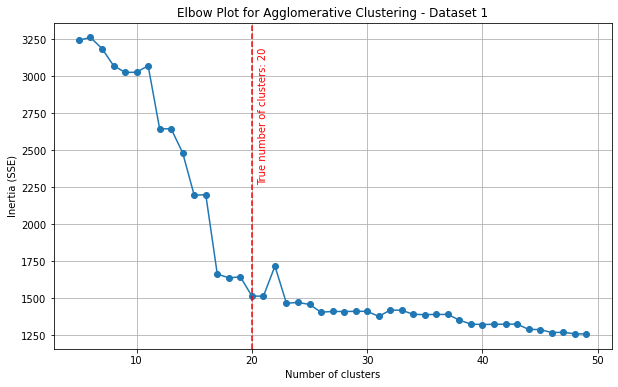

In [13]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(n_clusters_range, inertia_values_agg1, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Plot for Agglomerative Clustering - Dataset 1')
plt.axvline(x=20, color='r', linestyle='--')  # Add vertical dashed line at x=20
plt.text(20.5, max(inertia_values_agg1) * 0.7, 'True number of clusters: 20', rotation=90, color='r')  # Add label for the line
plt.grid(True)
plt.show()

In [21]:
# elbow plot for the first dataset
inertia_values_agg2 = []
n_clusters_range = range(5, 50)

# For each number of clusters, apply agglomerative clustering and calculate inertia
for n_clusters in n_clusters_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='cosine')
    labels = agg_clustering.fit_predict(X2)
    cluster_centers = np.array([X2[labels == i].mean(axis=0) for i in range(n_clusters)])
    inertia = sum(np.min(np.linalg.norm(X2 - cluster_centers[labels], axis=1)) for labels in labels)
    inertia_values_agg2.append(inertia)

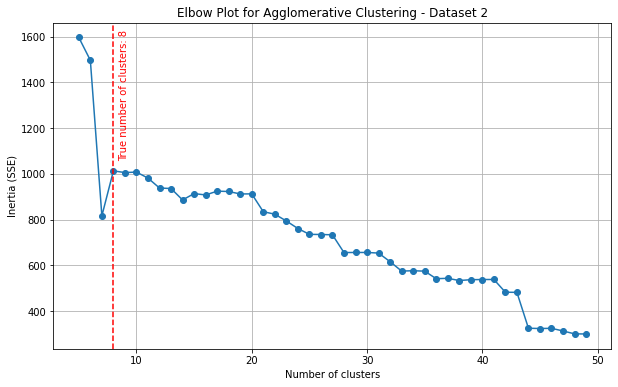

In [24]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(n_clusters_range, inertia_values_agg2, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Plot for Agglomerative Clustering - Dataset 2')
plt.axvline(x=8, color='r', linestyle='--')  # Add vertical dashed line at x=20
plt.text(8.5, max(inertia_values_agg2) * 0.67, 'True number of clusters: 8', rotation=90, color='r')  # Add label for the line
plt.grid(True)
plt.show()

In [27]:
# elbow plot for the first dataset
inertia_values_agg3 = []
n_clusters_range = range(5, 50)

# For each number of clusters, apply agglomerative clustering and calculate inertia
for n_clusters in n_clusters_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='cosine')
    labels = agg_clustering.fit_predict(X3)
    cluster_centers = np.array([X3[labels == i].mean(axis=0) for i in range(n_clusters)])
    inertia = sum(np.min(np.linalg.norm(X3 - cluster_centers[labels], axis=1)) for labels in labels)
    inertia_values_agg3.append(inertia)

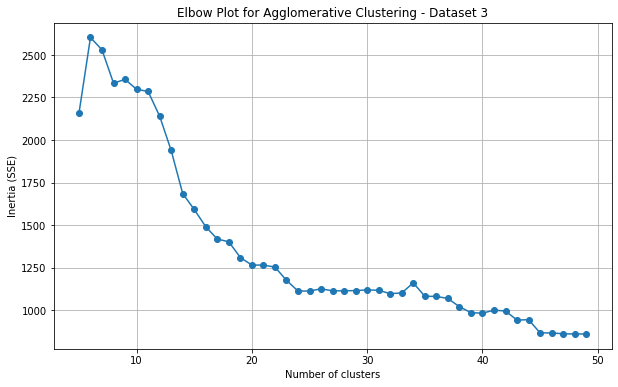

In [28]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(n_clusters_range, inertia_values_agg3, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Plot for Agglomerative Clustering - Dataset 3')
plt.grid(True)
plt.show()

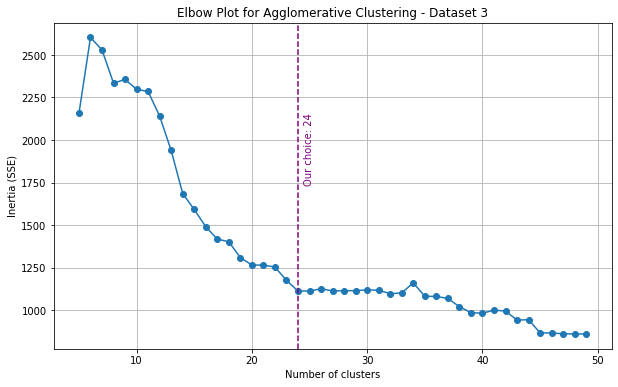

In [30]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(n_clusters_range, inertia_values_agg3, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Plot for Agglomerative Clustering - Dataset 3')
plt.axvline(x=24, color='purple', linestyle='--')  # Add vertical dashed line at x=20
plt.text(24.5, max(inertia_values_agg3) * 0.67, 'Our choice: 24', rotation=90, color='purple')  # Add label for the line
plt.grid(True)
plt.show()